In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo

In [3]:
zqso=5.887
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

In [4]:
Req=18 #pMpc
xi=0.67
kapbg=10**(-24.5) #cm^-2 wrong, cm^-1

In [5]:
def kap(drArr,Req,xi,kapbg):
    """
    Calculate kappa profile given inputs.

    Parameters:
    - drArr: array of radial step sizes in pMpc
    - Req: characteristic scale in pMpc, where \Gamma_qso==\Gamma_bkg assuming pure geometric dillusion
    - xi: power-law index
    - kapbg: background opacity in 1/pMpc

    Returns:
    - kapr: array of kappa values at each radial step
    """
    rArr=np.cumsum(drArr)
    kapbg*=3.08e24 #convert to 1/pMpc
    Gq_o_Gbg=np.zeros_like(rArr)
    kapr=np.zeros_like(rArr)
    kapr[0]=0
    Gq_o_Gbg[0]=(rArr[0]/Req)**(-2) #Eq7
    for i in range(1,len(rArr)):
        kapr[i]=kapbg*(1+Gq_o_Gbg[i-1])**(-xi) #Eq4
        Gq_o_Gbg[i]=Gq_o_Gbg[i-1]*(rArr[i]/rArr[i-1])**(-2)*np.exp(-kapr[i-1]*drArr[i-1]) #Eq8
    return kapr#,Gq_o_Gbg

In [6]:
def tau_LyC(wv_rest,Req,xi,kapbg,debug=True):
    z912=wv_rest/911.76*(1+zqso)-1
#     print(z912)
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
#     print(np.sum(drArr))
#     print((911.76-wv_rest)/911.76*clight.to("km/s").value/Hz)
    kap_zp=kap(drArr,Req,xi,kapbg)
    
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    tau_eff=clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ
#     if debug==True:
#         return drArr,kap_zp,tau_eff
    return tau_eff

def convert_mfp_kapbg(wv_rest,kapbg):
    z912=wv_rest/911.76*(1+zqso)-1
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
    kap_zp=np.ones_like(drArr)*kapbg*3.08e24
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    return clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ

### load data

In [7]:
wv_rest_arr=np.loadtxt("AAout.txt")
qso_t1e7_tau_profiles=np.loadtxt("qso_t1e7_tau_profiles.txt")

In [8]:
mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)

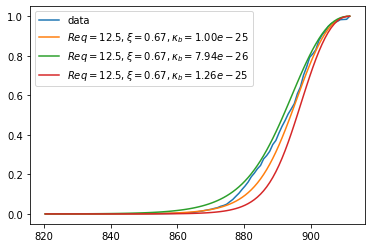

In [13]:
plt.plot(wv_rest_arr,mean_p,label="data")


Req=12.5 #pMpc
xi=0.67
kapbg=10**(-25.) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$Req={:3.1f},\xi={:4.2f},\kappa_b={:4.2e}$".format(Req,xi,kapbg))


Req=12.5 #pMpc
xi=0.67
kapbg=10**(-25.1) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$Req={:3.1f},\xi={:4.2f},\kappa_b={:4.2e}$".format(Req,xi,kapbg))



Req=12.5 #pMpc
xi=0.67
kapbg=10**(-24.9) #cm^-2 wrong, cm^-1

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$Req={:3.1f},\xi={:4.2f},\kappa_b={:4.2e}$".format(Req,xi,kapbg))


plt.legend()